# Australian Stock Prices Prediction

### Author: Phuc An Nguyen 

**August 2023**

## 1. Introduction

Stock market analysis and prediction is an important part of the stock trading and investing process. The benefits from performing this analysis include: Making smart investment decisions, Investment orientation, Understand the business, Risk forecast, Investment strategy orientation and Monitor investment performance.

This project will use Descriptive analysis to identify patterns in time series data, like trends, cycles, or seasonal variation as well as highlights the main characteristics of the time series data. Futhermore, I will use the Forecasting model for predicting future data based on the historical data with different types. Then I will evaluate and compare the performance of these models against each other and choose the best model. Finally, I will answer the inspiration questions raised at the beginning of the project.

### 1.1. Data description 

This dataset contains historical share price data from the top 100 companies (with 100 different CSV files) listed on the Australian Securities Exchange, each data file contains:
- **Date**: date
- **Open**: opening price
- **High**: high price
- **Low**: low price
- **Close**: closing price
- **Adj Close**: adjusted closing price (including dividends)
- **Volume**: trading volume

### 1.2. Inspiration questions

1. Which stocks have high value, high trading volume and low volatility?
2. What periods of the year are stocks most volatile?
3. Investors can profit by making smart decisions about buying, selling or holding stocks by predicting stock trends.

### 1.3. Import libraries

In [86]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split

# LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings('ignore')

## 2. Read multiple CSV file 

In [2]:
# Set the path to the folder containing the CSV files
folder_path = 'dataset'

# Create an empty list to store the data from all the CSV files
data_frames = []

# Create an empty list to store the names of the files
file_names = []

# Loop through the files in the folder, check if they are CSV files
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        # Add the name of the file as a new column to the DataFrame
        df['Company'] = file_name
        data_frames.append(df)
        # Store the name of the file in the file_names list
        file_names.append(file_name)

# After the loop, data_frames will contain all the DataFrames from the CSV files in the folder
# file_names will contain the names of all the CSV files in the folder
# To combine all the DataFrames into a single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)

## 3. Exploratory Data Analysis (EDA)

### 3.1. Data Exploration

In [3]:
combined_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,2015-03-31,0.555,0.595,0.530,0.565,0.565,4816294.0,A2M.csv
1,2015-04-01,0.575,0.580,0.555,0.565,0.565,4376660.0,A2M.csv
2,2015-04-02,0.560,0.565,0.535,0.555,0.555,2779640.0,A2M.csv
3,2015-04-07,0.545,0.550,0.540,0.545,0.545,392179.0,A2M.csv
4,2015-04-08,0.545,0.545,0.530,0.540,0.540,668446.0,A2M.csv


In [4]:
# Check dataframe shape
combined_df.shape

(432888, 8)

In [5]:
# Check null
combined_df.isnull().sum()

Date            0
Open         1527
High         1527
Low          1527
Close        1527
Adj Close    1527
Volume       1527
Company         0
dtype: int64

In [6]:
# Check information dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432888 entries, 0 to 432887
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       432888 non-null  object 
 1   Open       431361 non-null  float64
 2   High       431361 non-null  float64
 3   Low        431361 non-null  float64
 4   Close      431361 non-null  float64
 5   Adj Close  431361 non-null  float64
 6   Volume     431361 non-null  float64
 7   Company    432888 non-null  object 
dtypes: float64(6), object(2)
memory usage: 26.4+ MB


In [7]:
# summarizes dataframe
combined_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,431361.000000,431361.000000,431361.000000,431361.000000,431361.000000,4.313610e+05
mean,13.628159,13.765587,13.486251,13.626580,10.388578,3.646548e+06
std,19.325604,19.506007,19.140934,19.325726,17.343674,7.011357e+06
min,0.004000,0.004000,0.004000,0.004000,0.002449,0.000000e+00
25%,3.490000,3.530730,3.450000,3.490000,2.229591,5.879090e+05
50%,7.200000,7.275480,7.110000,7.196750,5.001390,1.799148e+06
75%,15.888700,16.040001,15.698000,15.866700,11.451574,4.207143e+06
max,339.420013,342.750000,337.029999,341.000000,339.376190,9.930183e+08


In [8]:
# Check negative or zero value
(combined_df[['Open','High','Low','Close','Adj Close']].values <= 0).any()

False

### 3.2. Data Wrangling

**Removing Rows with Null Values**

In [9]:
# Removing all Null rows in dataframe
df = combined_df.dropna()

**Change type Date column**

In [10]:
# Change the type of Date column from string to datetime
df['Date'] = pd.to_datetime(df['Date'])

**Change Company value**

In [11]:
# Change the Company name without .csv 
df['Company'] = df['Company'].str.replace('.csv', '')

**Change Date into Weekday and Quarter**

In [12]:
df['Day_of_week'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.to_period('Q')

In [13]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Company,Day_of_week,Quarter
0,2015-03-31,0.555,0.595,0.530,0.565,0.565,4816294.0,A2M,Tuesday,2015Q1
1,2015-04-01,0.575,0.580,0.555,0.565,0.565,4376660.0,A2M,Wednesday,2015Q2
2,2015-04-02,0.560,0.565,0.535,0.555,0.555,2779640.0,A2M,Thursday,2015Q2
3,2015-04-07,0.545,0.550,0.540,0.545,0.545,392179.0,A2M,Tuesday,2015Q2
4,2015-04-08,0.545,0.545,0.530,0.540,0.540,668446.0,A2M,Wednesday,2015Q2


**Get top 5 companies with the highest volume**

In [14]:
# Calculate sum of volume and get top 5 companies
top_volume_df = df.groupby(['Company'])['Volume'].agg('sum').reset_index()
top_volume_df = top_volume_df.sort_values(by="Volume", ascending=False).head(5)

In [15]:
# Filter the dataframe keep top 5 companies
company_list = top_volume_df['Company'].tolist()
df = df[df['Company'].isin(company_list)]

In [16]:
df.shape

(25716, 10)

### 3.3. Data Visualization

In [17]:
company_list

['TLS', 'BHP', 'AWC', 'FMG', 'QAN']

In [18]:
# Split big dataframe into different company dataframes  
TLS_df = df.loc[df['Company'] == 'TLS']
BHP_df = df.loc[df['Company'] == 'BHP']
AWC_df = df.loc[df['Company'] == 'AWC']
FMG_df = df.loc[df['Company'] == 'FMG']
QAN_df = df.loc[df['Company'] == 'QAN']

### Opening price

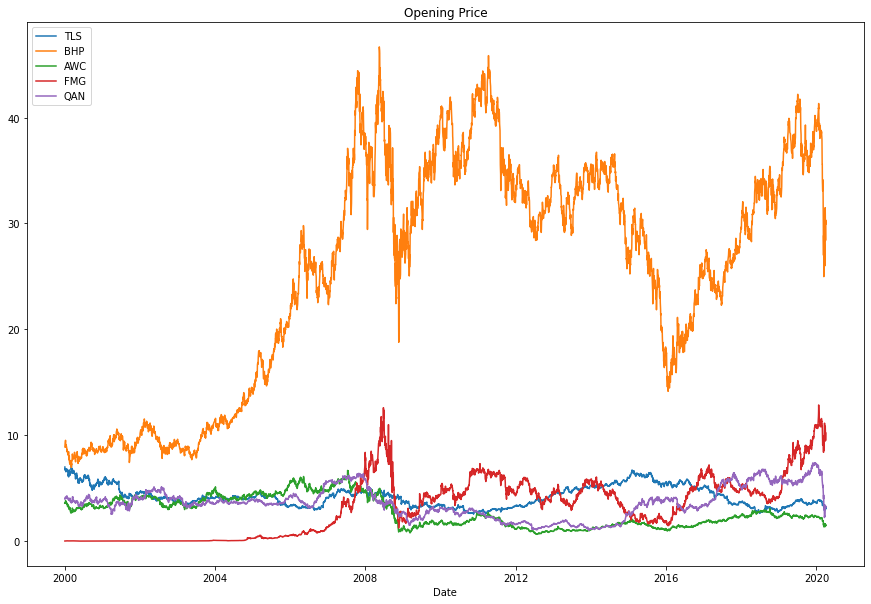

In [19]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(TLS_df['Date'], TLS_df['Open'], label="TLS")
ax.plot(BHP_df['Date'], BHP_df['Open'], label="BHP")
ax.plot(AWC_df['Date'], AWC_df['Open'], label="AWC")
ax.plot(FMG_df['Date'], FMG_df['Open'], label="FMG")
ax.plot(QAN_df['Date'], QAN_df['Open'], label="QAN")
ax.set_xlabel('Date')
ax.set_title('Opening Price')
plt.legend()

### Closed Price

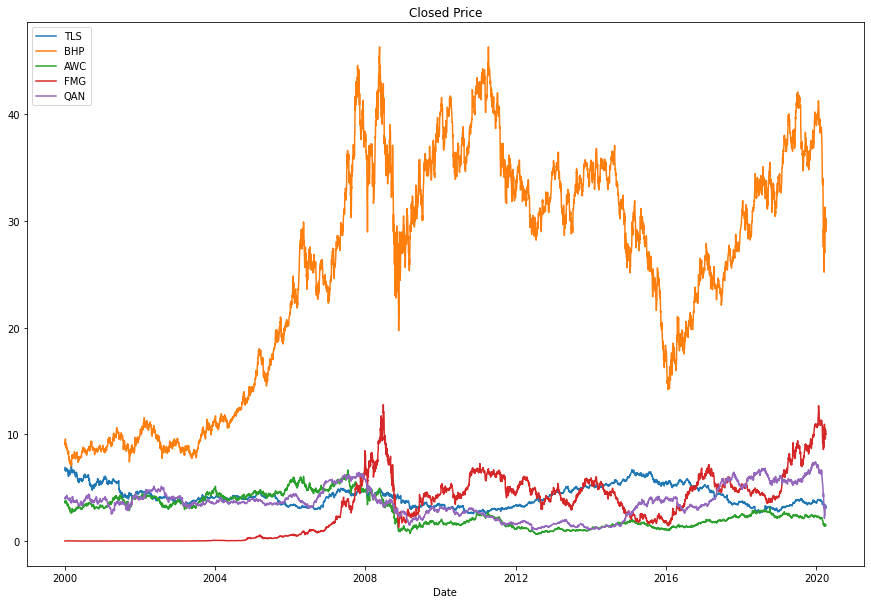

In [20]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(TLS_df['Date'], TLS_df['Close'], label="TLS")
ax.plot(BHP_df['Date'], BHP_df['Close'], label="BHP")
ax.plot(AWC_df['Date'], AWC_df['Close'], label="AWC")
ax.plot(FMG_df['Date'], FMG_df['Close'], label="FMG")
ax.plot(QAN_df['Date'], QAN_df['Close'], label="QAN")
ax.set_xlabel('Date')
ax.set_title('Closed Price')
plt.legend()

### Volume

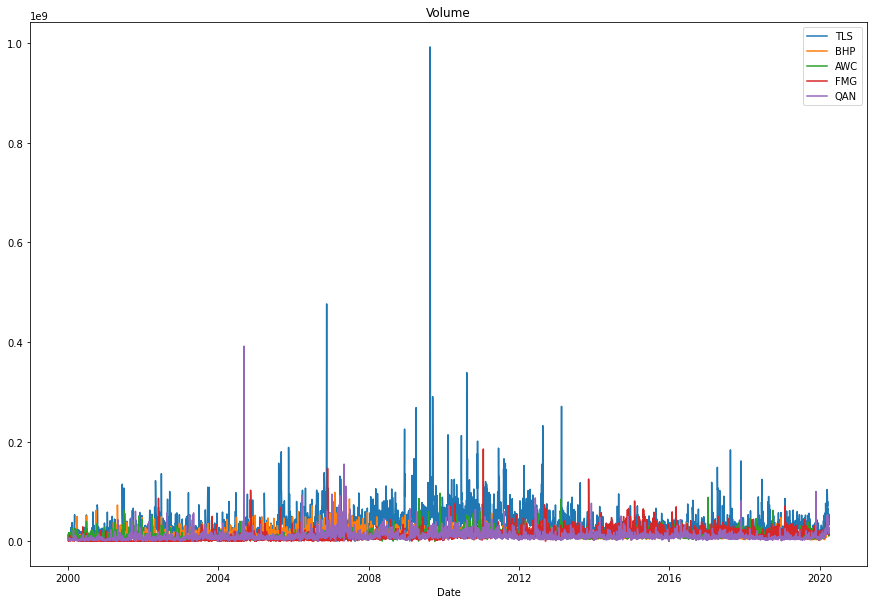

In [21]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(TLS_df['Date'], TLS_df['Volume'], label="TLS")
ax.plot(BHP_df['Date'], BHP_df['Volume'], label="BHP")
ax.plot(AWC_df['Date'], AWC_df['Volume'], label="AWC")
ax.plot(FMG_df['Date'], FMG_df['Volume'], label="FMG")
ax.plot(QAN_df['Date'], QAN_df['Volume'], label="QAN")
ax.set_xlabel('Date')
ax.set_title('Volume')
plt.legend()

### Distribution of Low vs High price 

In [22]:
TLS_df_melted = pd.melt(TLS_df[['Low', 'High']])
BHP_df_melted = pd.melt(BHP_df[['Low', 'High']])
AWC_df_melted = pd.melt(AWC_df[['Low', 'High']])
FMG_df_melted = pd.melt(FMG_df[['Low', 'High']])
QAN_df_melted = pd.melt(QAN_df[['Low', 'High']])

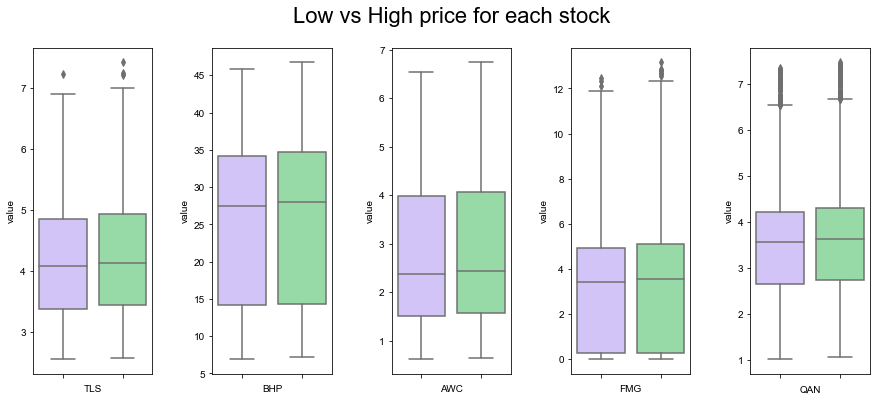

In [23]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
sns.set_theme(style="ticks", palette="pastel")

# add padding between the subplots
plt.subplots_adjust(wspace=0.5) 

# draw boxplot for age in the 1st subplot
sns.boxplot(x='variable', y='value', data=TLS_df_melted, 
            palette=["m", "g"], ax=ax[0])
ax[0].set_xlabel('TLS')

# draw boxplot for station_distance in the 2nd subplot
sns.boxplot(x='variable', y='value', data=BHP_df_melted, 
            palette=["m", "g"], ax=ax[1])
ax[1].set_xlabel('BHP')

# # draw boxplot for stores_count in the 3rd subplot
sns.boxplot(x='variable', y='value', data=AWC_df_melted, 
            palette=["m", "g"], ax=ax[2])
ax[2].set_title('Low vs High price for each stock', fontdict={'size': 22}, pad=25)
ax[2].set_xlabel('AWC')

# # finally draw boxplot for unit_price in the 4th subplot
sns.boxplot(x='variable', y='value', data=FMG_df_melted, 
            palette=["m", "g"], ax=ax[3])
ax[3].set_xlabel('FMG')

# # finally draw boxplot for unit_price in the 4th subplot
sns.boxplot(x='variable', y='value', data=QAN_df_melted, 
            palette=["m", "g"], ax=ax[4])
ax[4].set_xlabel('QAN')

# by default, you'll see x-tick label set to 0 in each subplot
# remove it by setting it to empty list
for subplot in ax:
    subplot.set_xticklabels([])

plt.show()

### Total trading volume by quarter

In [24]:
# Group by dataframe follow the company and quarter and get sum of volume
quarter_df = df.groupby(['Company','Quarter'])['Volume'].sum().reset_index()

In [25]:
# Get the quarter from 2014 t0 2020
quarter_df = quarter_df[~quarter_df['Quarter'].astype(str).str.startswith('200')]
quarter_df = quarter_df[~quarter_df['Quarter'].astype(str).str.startswith('2010')]
quarter_df = quarter_df[~quarter_df['Quarter'].astype(str).str.startswith('2011')]
quarter_df = quarter_df[~quarter_df['Quarter'].astype(str).str.startswith('2012')]
quarter_df = quarter_df[~quarter_df['Quarter'].astype(str).str.startswith('2013')]

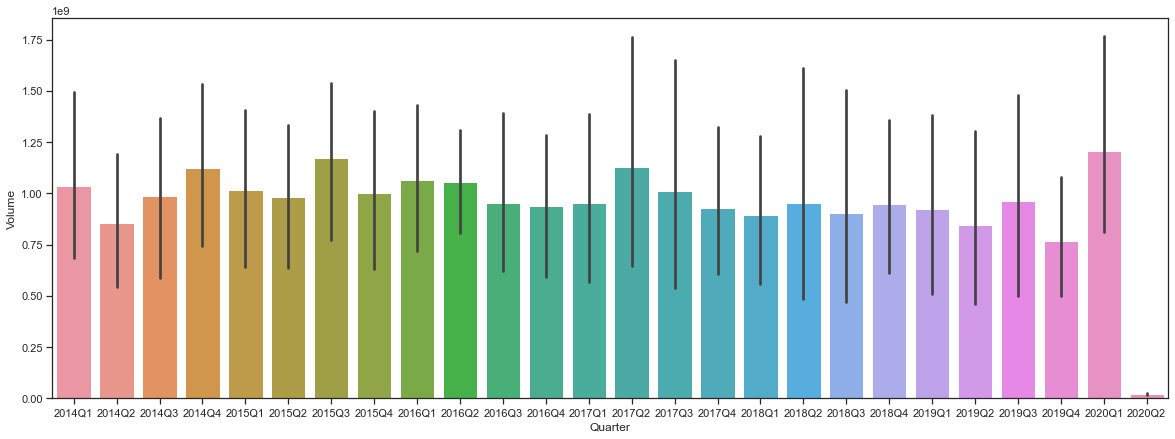

In [26]:
fig = plt.figure(figsize =(20, 7))
sns.barplot(x = 'Quarter', y = 'Volume', data = quarter_df)

plt.show()

### Average Closed price by quarter

In [27]:
# Group by dataframe follow the company and quarter and get average of close price
quarter_close_df = df.groupby(['Company','Quarter'])['Close'].mean().reset_index()

# Get the quarter from 2014 t0 2020
quarter_close_df = quarter_close_df[~quarter_close_df['Quarter'].astype(str).str.startswith('200')]
quarter_close_df = quarter_close_df[~quarter_close_df['Quarter'].astype(str).str.startswith('2010')]
quarter_close_df = quarter_close_df[~quarter_close_df['Quarter'].astype(str).str.startswith('2011')]
quarter_close_df = quarter_close_df[~quarter_close_df['Quarter'].astype(str).str.startswith('2012')]
quarter_close_df = quarter_close_df[~quarter_close_df['Quarter'].astype(str).str.startswith('2013')]

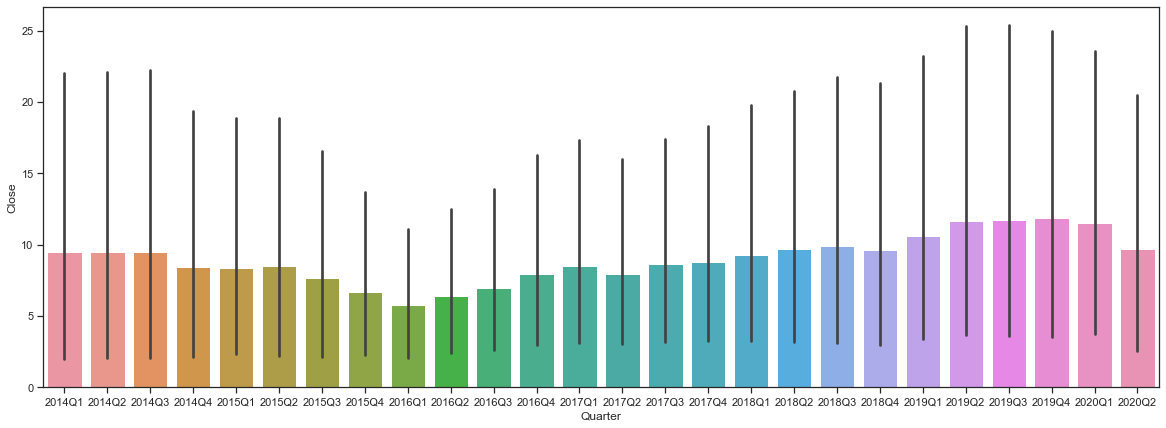

In [28]:
fig = plt.figure(figsize =(20, 7))
sns.barplot(x = 'Quarter', y = 'Close', data = quarter_close_df)

plt.show()

### EDA Summary
In this section, I had a better insight into the data set and at the same time provided specific results for the selection and creation of suitable models for this data. Important discoveries found in this section include:
- Data processing steps include removing rows with null values, change type Date column, change company value, change Date into Weekday and Quarter.
- After performing data wrangling, we shorten the data (from 432888 to 25716 rows and 10 factors with no null value) to further analyze the top 5 stocks with the highest total trading volume.
- Data types in the dataset include datetime, float, and object.
- Use multiple line charts to show the opening price, closing price, and volume of the 5 analyzed stocks from 2000 to 2020.
- Use box plot to see the division of Low versus High price for each stock.
- Use bar chart to show the Total trading and Average Closed price by quarter for all stocks from 2014 to 2020.

## 4. Methodology
### 4.1. Modelling methods

The time series analysis in this project uses statistical methods and machine learning to analyze time data and make predictions or inferences about the future. There will be developed with 3 models builts, including:
- **Time Series Models**: ARIMA (AutoRegressive Integrated Moving Average)
- **Deep Learning Models**: LSTM (Long Short-Term Memory)
- **Ensemble Models**: Random Forest Classifier

### 4.2. Model evaluation methods

Data science places a lot of importance on model evaluation. It makes it simple for you to communicate your model to others and lets you see how well your model is performing and how closely your forecast matches the actual value. \
The assessment measures that will ultimately be used to assess and choose the model with the greatest performance are described below. Each of them has unique strengths and limitations, and they were chosen to serve as the foundation for an assessment that is as objective as possible.

- **Mean Absolute Percentage Error (MAPE)**:
$$ MAPE = \frac{1}{N} \sum^{N}_{i=1}{|\frac{y_{i} - \hat{y_{i}}}{y_{i}}|} $$

- **Root Mean Squared Error (RMSE)**:
$$ RMSE = \sqrt{\frac{1}{N} \sum^{N}_{i=1}{(y_{i} - \hat{y_{i}})^2}} $$


- **Mean Absolute Error (MAE)**:
$$ MAE = \frac{1}{N} \sum^{N}_{i=1}{|y_{i} - \hat{y_{i}}|} $$

### 4.3. Data preparation

### Setting up the target

In [29]:
# Remove the extra columns that we don't need
TLS_df = TLS_df.drop(columns=["Adj Close", "Company", "Day_of_week", "Quarter"])

# Make Date column to index
TLS_df.set_index('Date', inplace=True)
TLS_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,7.00044,7.00044,6.88222,6.89066,8203436.0
2000-01-05,6.75555,6.81466,6.69644,6.75555,9600494.0
2000-01-06,6.79778,6.84844,6.71333,6.71333,9683533.0
2000-01-07,6.70066,6.73866,6.58666,6.62044,13613336.0
2000-01-10,6.75555,6.75555,6.69644,6.71333,6067734.0


## 5. Model Development 

### 5.1. ARIMA (AutoRegressive Integrated Moving Average)

ARIMA Models are specified by three order parameters: (p, d, q), where,

- p is the order of the AR (Auto Regressive) term

- q is the order of the MA (Moving Average) term

- d is the number of differencing required to make the time series stationary

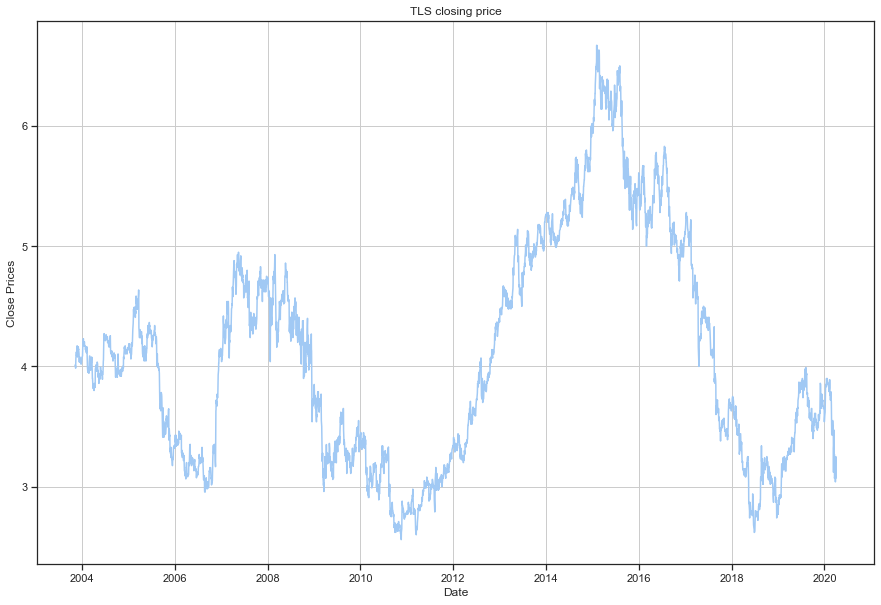

In [92]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(TLS_df['Close'])
plt.title('TLS closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

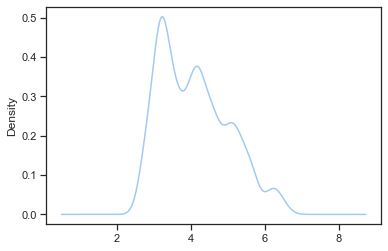

In [93]:
#Distribution of the dataset
df_close = TLS_df['Close']
df_close.plot(kind='kde')


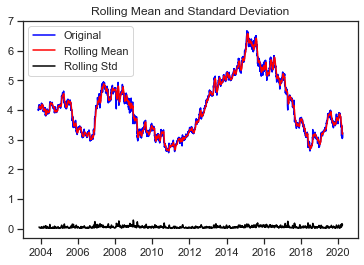

Results of dickey fuller test
Test Statistics                  -1.473100
p-value                           0.546774
No. of lags used                  3.000000
Number of observations used    4151.000000
critical value (1%)              -3.431926
critical value (5%)              -2.862237
critical value (10%)             -2.567141
dtype: float64


In [94]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


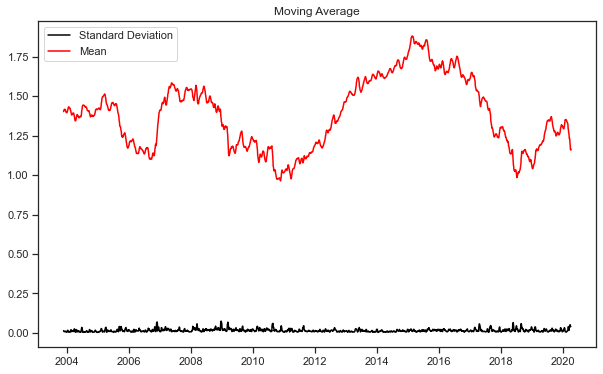

In [97]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

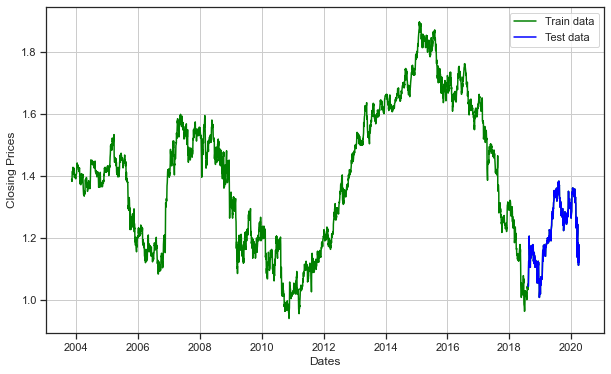

In [98]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21944.965, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21943.835, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21943.880, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21946.770, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21935.588, Time=0.69 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.884 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3736
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10974.385
Date:                Tue, 12 Sep 2023   AIC                         -21946.770
Time:                        23:01:30   BIC                         -21940.544
Sample:                             0   HQIC                        -21944.555
                               - 3736                             

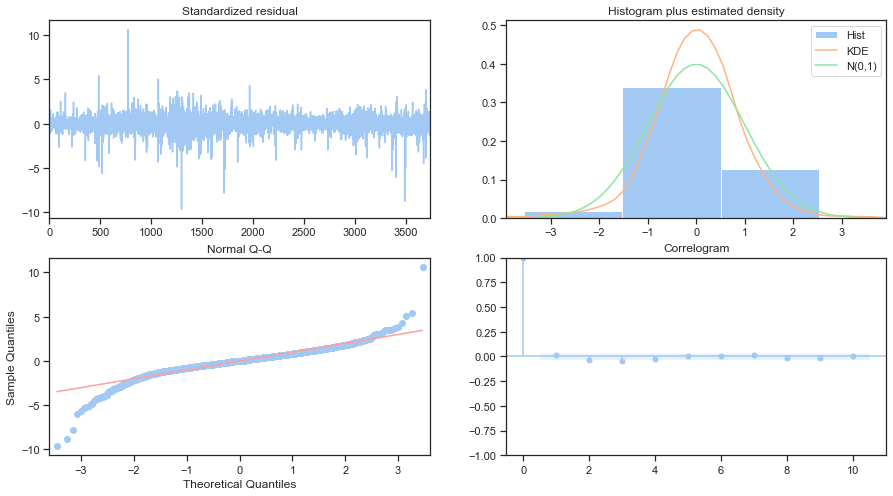

In [99]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [101]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3736
Model:                 ARIMA(0, 1, 0)   Log Likelihood               10974.385
Date:                Tue, 12 Sep 2023   AIC                         -21946.770
Time:                        23:06:08   BIC                         -21940.544
Sample:                             0   HQIC                        -21944.555
                               - 3736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.49e-06    110.454      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):             19243.21
Prob(Q):                              0.35   Pr

In [103]:
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

TypeError: 'float' object is not subscriptable

In [ ]:
# Build Model
model = ARIMA(train_data, order=(3,1,0))  
fitted = model.fit()  
print(fitted.summary())

https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

### Evaluating model

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

### 5.2. Long Short-Term Memory (LSTM)

### Setting the Target Variable and Selecting the Features

In [56]:
#Set Target Variable
output_var = pd.DataFrame(TLS_df['Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

### Scale 
We will scale the stock values to values between 0 and 1 in order to reduce the processing cost of the data in the table. As a consequence, the total amount of data in huge numbers is minimised, which lowers memory use. Additionally, because the data is not dispersed across large numbers, scaling down allows for higher precision.

In [58]:
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(TLS_df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=TLS_df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2003-11-07,0.356145,0.354115,0.358684,0.009364
2003-11-10,0.352075,0.348031,0.354514,0.012770
2003-11-11,0.350041,0.346005,0.354514,0.014913
2003-11-12,0.350041,0.343978,0.352427,0.016541
2003-11-13,0.350041,0.354115,0.356598,0.014894


In [60]:
# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

### Data Processing For LSTM
The data from the training and test sets must be transformed into a form that the LSTM model can understand. We first convert the training and test data to NumPy arrays and then reorganise them to comply with the format since the LSTM requires that the data be supplied in the 3D form (Number of Samples, 1, Number of Features). Likewise, the test set is reshaped.

In [61]:
# Process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

### Building the LSTM Model

In [77]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [78]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
473/473 [==============================] - 1s 903us/step - loss: 5.9630
Epoch 2/100
473/473 [==============================] - 0s 875us/step - loss: 0.1465
Epoch 3/100
473/473 [==============================] - 0s 872us/step - loss: 0.0685
Epoch 4/100
473/473 [==============================] - 0s 877us/step - loss: 0.0330
Epoch 5/100
473/473 [==============================] - 0s 881us/step - loss: 0.0178
Epoch 6/100
473/473 [==============================] - 0s 877us/step - loss: 0.0110
Epoch 7/100
473/473 [==============================] - 0s 889us/step - loss: 0.0077
Epoch 8/100
473/473 [==============================] - 0s 921us/step - loss: 0.0058
Epoch 9/100
473/473 [==============================] - 0s 889us/step - loss: 0.0045
Epoch 10/100
473/473 [==============================] - 0s 855us/step - loss: 0.0036
Epoch 11/100
473/473 [==============================] - 0s 870us/step - loss: 0.0030
Epoch 12/100
473/473 [==============================] - 0s 898us/step - lo

473/473 [==============================] - 0s 874us/step - loss: 7.0702e-04
Epoch 96/100
473/473 [==============================] - 0s 901us/step - loss: 7.0351e-04
Epoch 97/100
473/473 [==============================] - 0s 875us/step - loss: 7.0010e-04
Epoch 98/100
473/473 [==============================] - 0s 886us/step - loss: 6.9631e-04
Epoch 99/100
473/473 [==============================] - 0s 900us/step - loss: 6.9241e-04
Epoch 100/100
473/473 [==============================] - 0s 884us/step - loss: 6.8879e-04


### Making the LSTM Prediction 

In [79]:
#LSTM Prediction
y_pred = lstm.predict(X_test)

12/12 [==============================] - 0s 1ms/step


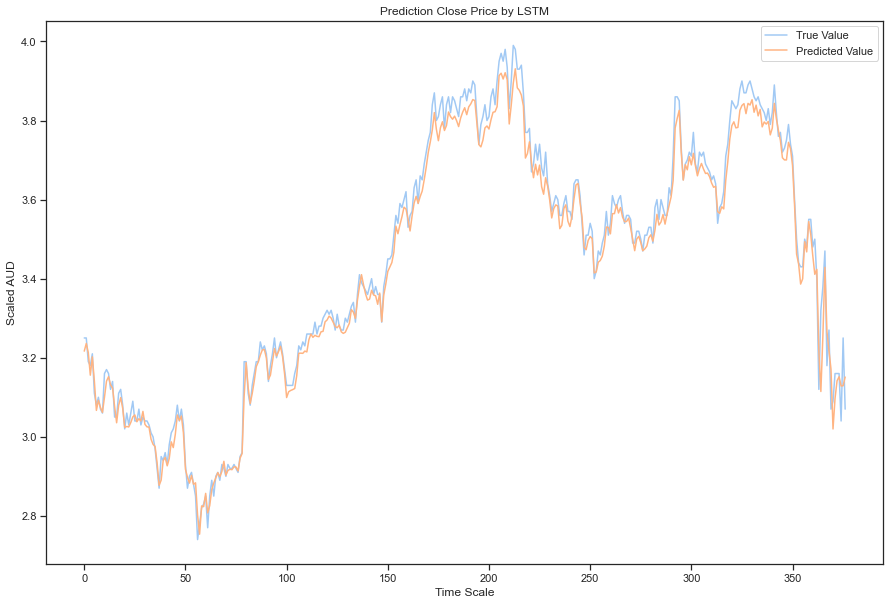

In [83]:
# Predicted vs True Adj Close Value – LSTM
fig,ax = plt.subplots(figsize=(15,10))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='Predicted Value')
plt.title("Prediction Close Price by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled AUD')
plt.legend()
plt.show()

### Evaluating model

In [87]:
mse = mean_squared_error(y_test, y_pred)
print('MSE: '+ str(mse))
mae = mean_absolute_error(y_test, y_pred)
print('MAE: '+ str(mae))
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: '+ str(rmse))
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('MAPE: '+ str(mape))

MSE: 0.0013021825306672656
MAE: 0.02777590344375893
RMSE: 0.03608576631675245
MAPE: 0.10594655800487583


### 5.3. Random Forest Classifier (RFC)

In [30]:
# Shift the close price, which mean the next day to be the tomorrow's price
TLS_df['Tomorrow'] = TLS_df['Close'].shift(-1)
TLS_df.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
2000-01-04,7.00044,7.00044,6.88222,6.89066,8203436.0,6.75555
2000-01-05,6.75555,6.81466,6.69644,6.75555,9600494.0,6.71333
2000-01-06,6.79778,6.84844,6.71333,6.71333,9683533.0,6.62044
2000-01-07,6.70066,6.73866,6.58666,6.62044,13613336.0,6.71333
2000-01-10,6.75555,6.75555,6.69644,6.71333,6067734.0,6.62044


In [31]:
# Set the target that we try to predict called 'Target'
# return the boolean value, 1 if tomorrow > today's price, otherwise 0
TLS_df['Target'] = (TLS_df['Tomorrow'] > TLS_df['Close']).astype(int)
TLS_df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-04,7.00044,7.00044,6.88222,6.89066,8203436.0,6.75555,0
2000-01-05,6.75555,6.81466,6.69644,6.75555,9600494.0,6.71333,0
2000-01-06,6.79778,6.84844,6.71333,6.71333,9683533.0,6.62044,0
2000-01-07,6.70066,6.73866,6.58666,6.62044,13613336.0,6.71333,1
2000-01-10,6.75555,6.75555,6.69644,6.71333,6067734.0,6.62044,0


In [32]:
TLS_df.shape

(5156, 7)

### Train the initial model

Parameters for the RFC model:
- **n_estimators**: the number of individual decision trees
- **min_samples_split**: this help us protect against overfitting 
- **random_state**: if we run the same model twice, the random numbers that generated will be in a predictable sequence, which means we'll get the same result

In [39]:
# Training the initial model
RFC_model = RandomForestClassifier(n_estimators = 100, 
                                   min_samples_split = 100, 
                                   random_state = 1)

# Split train set and test set
train = TLS_df.iloc[:-100]
test = TLS_df.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
RFC_model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [40]:
# Make prediction
preds = RFC_model.predict(test[predictors])

# Show prediction
preds = pd.Series(preds, index = test.index)
preds

Date
2019-11-08    0
2019-11-11    1
2019-11-12    1
2019-11-13    0
2019-11-14    0
             ..
2020-03-26    0
2020-03-27    0
2020-03-30    0
2020-03-31    0
2020-04-01    0
Length: 100, dtype: int32

In [41]:
# Calculate the precision score
precision_score(test["Target"], preds)

0.40540540540540543

### Plot prediction

<AxesSubplot:xlabel='Date'>

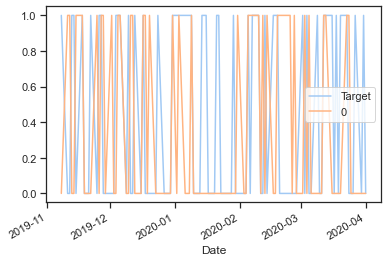

In [42]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

### Build backtesting system

In [43]:
# Create function to predict
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [44]:
# take the first 10-year of data and predict values for the 11th year
# then take the first 11-year of data and predict values for the 12th year
# and so on
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [45]:
# Predict
predictions = backtest(TLS_df, RFC_model, predictors)

In [46]:
# Count how many price go up and go down
predictions["Predictions"].value_counts()

0    1634
1    1022
Name: Predictions, dtype: int64

In [47]:
# Calculate the precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.4794520547945205

In [48]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.528991
1    0.471009
Name: Target, dtype: float64

=> this stock will go down 52.8% and go up 47.1%

### Adding additional predictors for the model

In [49]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = TLS_df.rolling(horizon).mean()
    
    # The ratio between today's close and the average close in the last 2 (5,60,250,1000) days
    ratio_column = f"Close_Ratio_{horizon}"
    TLS_df[ratio_column] = TLS_df["Close"] / rolling_averages["Close"]
    
    # The sum of days in the past 2 (5,60,250,1000) days is that the stock price actually went up
    trend_column = f"Trend_{horizon}"
    TLS_df[trend_column] = TLS_df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

In [50]:
TLS_df = TLS_df.dropna()

### Improving RFC model

In [51]:
RFC_model = RandomForestClassifier(n_estimators = 200, 
                                   min_samples_split = 50, 
                                   random_state = 1)

In [52]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    
    # Set the custom threshold
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [53]:
# Make prediction with new model
predictions = backtest(TLS_df, RFC_model, new_predictors)

In [54]:
predictions["Predictions"].value_counts()

0.0    1635
1.0      20
Name: Predictions, dtype: int64

### Evaluating model

In [55]:
# Calculate the precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.55

In [90]:
mse = mean_squared_error(predictions["Target"], predictions["Predictions"])
print('MSE: '+ str(mse))
mae = mean_absolute_error(predictions["Target"], predictions["Predictions"])
print('MAE: '+ str(mae))
rmse = math.sqrt(mean_squared_error(predictions["Target"], predictions["Predictions"]))
print('RMSE: '+ str(rmse))

MSE: 0.46404833836858006
MAE: 0.46404833836858006
RMSE: 0.6812109352972691


## 6. Conclusion

In the descriptive analysis, I came up with the following findings:

    1. The opening and closing prices of BHP shares were the highest, outperforming other stocks in 20 years.

    2. However, the trading volume of TLS stock is considered larger than that of the remaining stocks.

    3. The gap between the highest and lowest prices is not much. Although there are a few outliers, they do not have a significant impact. It is noticeable that because BHP shares are highly valued and highly volatile, the split in the highest and lowest prices is wider (about 40 compared to 4-12 for the remaining stocks).

    4. For all stocks, the total number of shares traded does not have a hard rule of how to increase or decrease in a particular quarter. For example, stocks may be heavily traded in the third quarter of 2015, but in 2017 the second quarter recorded the highest number of transactions of the year. On the other hand, for 2020, Q1 was recorded as the quarter with the largest total transactions.

    5. The same goes for the average closing price of all stocks, which is not known to increase or decrease in any given quarter of the year. Because the price of a stock can change daily and is affected by many different factors.

In the predictive analysis, I came up with the following conclusions:

- For **RandomForestClassifier**, although the precision score is not too high (0.55), it is acceptable. The recommendation is that you can try to change/add parameters (max_depth, min_sample_leaf, etc.) or additional predictors to improve the model accuracy. Furthermore, we can also try increasing the resolution, instead of looking at daily data, try to look at hourly or minute by minute data.

### References

The dataset is collected from source:
https://www.kaggle.com/datasets/ashbellett/australian-historical-stock-prices?resource=download

PETER ABRAHAMSSON, NIKLAS AHLQVIST. (2022). Evaluation of Machine Learning Methods for Time Series Forecasting on E-Commerce Data. Available: https://www.diva-portal.org/smash/get/diva2:1719774/FULLTEXT01.pdf